In [58]:
# Import the libraries we'll use below.
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import pydicom

from pandasql import sqldf

In [5]:
# Load train.csv into a dataframe
# This is metadata provided in addition to the dicom files
df = pd.read_csv(r"F:\rsna-breast-cancer-detection\train.csv")

In [6]:
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [7]:
df.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case'],
      dtype='object')

In [11]:
df.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


## Conclusions so far
- Count of image_ids matches number of files found traversing the file structure: 54,706 images
- Next, we'll look into why there are missing age and BIRADS data
- Checking for uniqueness of image_id will be useful
- Categorical bar plots / histograms / counts will be useful for most columns

# Look at missing data

In [12]:
df.shape

(54706, 14)

In [14]:
# Let's look at the missing datapoints
# Age, BIRADS, and density have missing data points
print(df.isna().sum())

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64


In [16]:
# Let's look at the rows with missing age
missing_age_rows = df[df['age'].isna()]

# display the selected rows
print(missing_age_rows)

# We notice the site_id is 1 in all cases
# machine id is 49 in all cases
# No cancer in all cases - which is by far the majority of the dataset
# A few difficult negative cases
# Not seeing a meaningful reason to keep nor delete this data. 
# Decide to keep it for now but if age becomes important, will either remove or set age to average from the rest of the dataset. 

       site_id  patient_id    image_id laterality view  age  cancer  biopsy  \
1850         1       11995  1129509810          L   CC  NaN       0       0   
1851         1       11995  1732220752          L  MLO  NaN       0       0   
1852         1       11995   776998051          R  MLO  NaN       0       0   
1853         1       11995  2123005479          R   CC  NaN       0       0   
12886        1       23752  1081106657          L   CC  NaN       0       0   
12887        1       23752  1106722394          L  MLO  NaN       0       0   
12888        1       23752   707585829          R  MLO  NaN       0       0   
12889        1       23752  1982432589          R   CC  NaN       0       0   
16230        1       27212   598973621          L  MLO  NaN       0       0   
16231        1       27212   660603973          L   CC  NaN       0       0   
16232        1       27212   727784450          R   CC  NaN       0       0   
16233        1       27212   900539670          R  M

In [20]:
# Let's take a quick look at the missing BIRADS
# select the rows where column B has missing values
missing_BIRADS_rows = df[df['BIRADS'].isna()]

# display the selected rows
print(missing_BIRADS_rows.describe())

# This is a significant number of datapoints 28420/54706 -> 52%
# Decide to not use BIRADS in algorithm

            site_id    patient_id      image_id           age        cancer  \
count  28420.000000  28420.000000  2.842000e+04  28412.000000  28420.000000   
mean       1.795778  32589.740676  1.077739e+09     59.886738      0.017382   
std        0.403139  18884.588586  6.174081e+08      8.868385      0.130693   
min        1.000000      5.000000  1.934590e+05     26.000000      0.000000   
25%        2.000000  16202.500000  5.459971e+08     54.000000      0.000000   
50%        2.000000  32354.000000  1.077389e+09     60.000000      0.000000   
75%        2.000000  48829.000000  1.612052e+09     66.000000      0.000000   
max        2.000000  65530.000000  2.147416e+09     89.000000      1.000000   

             biopsy      invasive  BIRADS       implant    machine_id  
count  28420.000000  28420.000000     0.0  28420.000000  28420.000000  
mean       0.021605      0.012949     NaN      0.008198     39.646129  
std        0.145391      0.113055     NaN      0.090175     26.255477  


## Conclusions so far
- N/As in age column: Will not delete data from those images unless age becomes important part of algorithm
- N/As in BIRADS: will not use the BIRADS information since this is a significant portion of the dataset (52%)
- N/As in density: will not use the density information since this is a significant portion of the dataset (46%)

# Check uniqueness of image_id

In [23]:
# check the uniqueness of values in column B
num_unique = df['image_id'].nunique()
num_total = df['image_id'].count()
if num_unique == num_total:
    print("All values in column B are unique.")
else:
    print("Column B has non-unique values.")

All values in column B are unique.


# Look at each column, including counts and histograms

## Conclusions
- Sites: 2 sites, somewhat even distribution acorss them
- Patients: 11,913 patients. Most patients have 4 images. 
- Cancer outcome is tied to breast not patient. A patient can have cancer in one breast and not the other. All images associated with a given breast have the same cancer outcome. 
- It's unclear why some patients have up to 14 images. It doesn't seem to be tied to presence of cancer. Since this is like counting the same data multiple times, I propose not using patient for whom there are more than 6 images. 

In [30]:
# Sites
# How many sites are there? ->2
# How is the data distributed across sites? -> 54% at site 1 and 46% at site 2
# Pretty even distribution
site_value_counts = df['site_id'].value_counts(normalize=True)*100
print('Sites:\n',site_value_counts.round(2))

Sites:
 1    53.96
2    46.04
Name: site_id, dtype: float64


In [56]:
8233/11913

0.6910937631159237

Patient count: 11913 

Counts of number of images per patient:
 4     8233
5     1767
6     1218
7      276
8      229
9       99
10      53
11      19
12      12
13       5
14       2
Name: patient_id, dtype: int64


<AxesSubplot:>

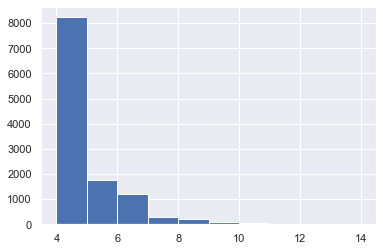

In [57]:
# Patients
# check number of patients
patient_n_unique = df['patient_id'].nunique()
print('Patient count:', patient_n_unique, '\n')

# table of number of images per patient
patient_value_counts = df['patient_id'].value_counts()
summary_patient_value_counts = patient_value_counts.value_counts()
print('Counts of number of images per patient:\n', summary_patient_value_counts)

# visualize number of images per patient
patient_value_counts.hist()

# Most patients have 4 images (69%)
# Other patients have up to 14 images
# In the next cell, let's look into why some patients have more images

In [95]:
# compute count of image_ids for each patient_id
image_counts = df.groupby('patient_id').size().reset_index(name='num_images')

# merge counts back into original DataFrame
df = df.merge(image_counts, on='patient_id')

print(df.head())

   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   
3         0     NaN        0     NaN          29                    False   
4         0     0.0        0     NaN          21                     True   

   num_images  
0           4  
1           4  
2           4  
3           4  


In [107]:
grouped = df.groupby(['num_images', 'cancer']).size().reset_index()
print(grouped)

    num_images  cancer      0
0            4       0  32314
1            4       1    618
2            5       0   8609
3            5       1    226
4            6       0   7128
5            6       1    180
6            7       0   1868
7            7       1     64
8            8       0   1798
9            8       1     34
10           9       0    860
11           9       1     31
12          10       0    525
13          10       1      5
14          11       0    209
15          12       0    144
16          13       0     65
17          14       0     28


In [120]:
print('Patients w/ 4 images. % with cancer:', round(618/32314,2), '%')
print('Patients w/ 5 images. % with cancer:',round(226/8609,2),'%')
print('Patients w/ 6 images. % with cancer:',round(180/7128,2), '%')
print('Patients w/ 7 images. % with cancer:',round(64/1868,2), '%')
print('Patients w/ 8 images. % with cancer:',round(34/1798,2), '%')
print('Patients w/ 9 images. % with cancer:',round(31/860,2), '%')
print('Patients w/ 10 images. % with cancer:',round(5/525,2), '%')
print('Patients w/ 11, 12, 13, or 14 images. % with cancer: 0%')

# Decision -> Let's get rid of the patients with 6+ images
# This is like counting the same patient multiple times

Patients w/ 4 images. % with cancer: 0.02 %
Patients w/ 5 images. % with cancer: 0.03 %
Patients w/ 6 images. % with cancer: 0.03 %
Patients w/ 7 images. % with cancer: 0.03 %
Patients w/ 8 images. % with cancer: 0.02 %
Patients w/ 9 images. % with cancer: 0.04 %
Patients w/ 10 images. % with cancer: 0.01 %
Patients w/ 11, 12, 13, or 14 images. % with cancer: 0%


In [121]:
# What proportion of images are omitted if we don't use the patients with 6+ images?

############# Fill this is

In [96]:
df.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case', 'num_images'],
      dtype='object')

In [62]:
# Why do some patients have more images?
# First let's look at number of cases with cancer - number of patients and number of images
# A total of 1157 images have positive cancer case
q = "SELECT patient_id, image_id FROM df WHERE cancer = 1"
result = sqldf(q, globals())
print(result)

      patient_id    image_id
0          10130   388811999
1          10130   613462606
2          10130  1360338805
3          10130  1672636630
4          10226   461614796
...          ...         ...
1153        9707  1900919592
1154        9840   111786935
1155        9840  1559360810
1156        9851  1409270544
1157        9851  1434430689

[1158 rows x 2 columns]


In [73]:
# Check if the outcome is the same for a given patient
q = """
    SELECT patient_id
    FROM (
        SELECT patient_id, COUNT(DISTINCT cancer) AS unique_outcomes
        FROM df
        GROUP BY patient_id
        ) 
    WHERE unique_outcomes > 1
    group by patient_id
"""

# run SQL query using pandasql
result = sqldf(q)
print(result)

     patient_id
0           106
1           236
2           283
3           500
4           729
..          ...
475       65222
476       65224
477       65244
478       65427
479       65492

[480 rows x 1 columns]


In [74]:
# Look at an example
q2 = """
    SELECT patient_id, image_id, laterality, cancer
    FROM df
    WHERE patient_id = 106
"""

# run SQL query using pandasql
result2 = sqldf(q2)
print(result2)

   patient_id    image_id laterality  cancer
0         106    76321767          L       1
1         106  2018825992          L       1
2         106  1160585918          R       0
3         106  1495797827          R       0


In [76]:
# check if outcome is the same for a given laterality for a given patient
# answer is yes -> outcome of cancer or not is per breast
q = """
    SELECT patient_id, laterality
    FROM (
        SELECT patient_id, laterality, COUNT(DISTINCT cancer) AS unique_outcomes
        FROM df
        GROUP BY patient_id, laterality
        ) 
    WHERE unique_outcomes > 1
    group by patient_id, laterality
"""

# run SQL query using pandasql
result = sqldf(q)
print(result)

Empty DataFrame
Columns: [patient_id, laterality]
Index: []


array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

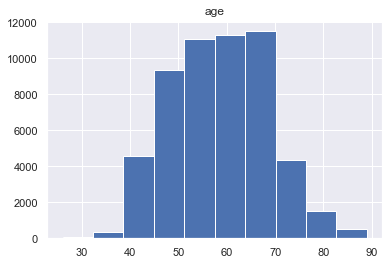

In [123]:
df.hist('age')

array([[<AxesSubplot:title={'center':'cancer'}>]], dtype=object)

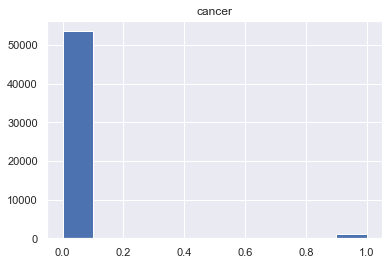

In [124]:
df.hist('cancer')
#we should probably baseline to the most likely case: no cancer

array([[<AxesSubplot:title={'center':'biopsy'}>]], dtype=object)

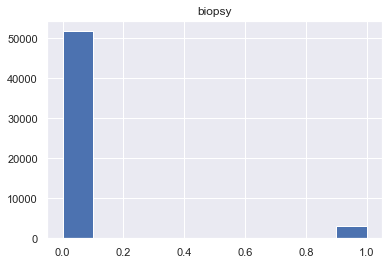

In [125]:
df.hist('biopsy')

array([[<AxesSubplot:title={'center':'invasive'}>]], dtype=object)

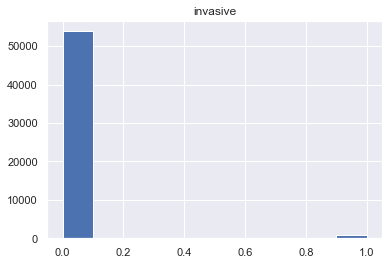

In [126]:
df.hist('invasive')

array([[<AxesSubplot:title={'center':'BIRADS'}>]], dtype=object)

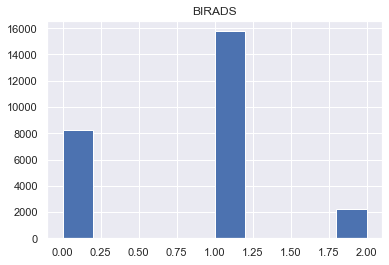

In [127]:
df.hist('BIRADS')

<AxesSubplot:>

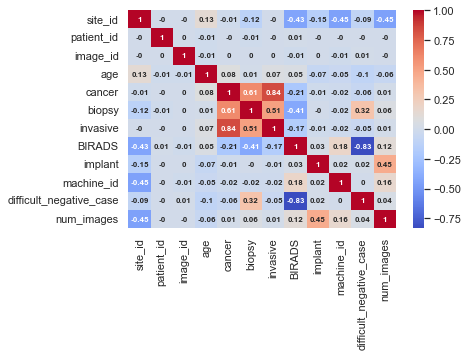

In [122]:
corr_matrix = df.corr()
rounded_corr_matrix = corr_matrix.round(2)
sns.heatmap(rounded_corr_matrix, annot=True, cmap='coolwarm', annot_kws={"fontsize":8, "fontweight": "bold", "ha": 'center', "va": 'center'})

In [129]:
pct_images_with_cancer = round(counts_cancer[1]/counts_cancer[0]*100,2)
pct_images_with_invasive_cancer = round(counts_invasive[1]/counts_invasive[0]*100,2)
pct_images_with_biopsy = round(counts_biopsy[1]/counts_biopsy[0]*100,2)
print('Portion of images with cancer:',pct_images_with_cancer ,'%')
print('Portion of images with invasive cancer:',pct_images_with_invasive_cancer ,'%')
print('Portion of images with biopsy:',pct_images_with_biopsy ,'%')

Portion of images with cancer: 2.16 %
Portion of images with invasive cancer: 1.52 %
Portion of images with biopsy: 5.74 %


In [130]:
#sanity check - are there any images with no cancer but with invasive
#passed check - All that are labeled as invasive are also labeled as cancer
df_check1 = df[(df['cancer'] == 0) & (df['invasive'] == 1)]
print(df_check1.shape)

(0, 15)


In [131]:
#print an example image with cancer
df_with_cancer = df[df['cancer'] == 1]
print(df_with_cancer.head())
print('Shape:',df_with_cancer.shape)
inds_cancer = df_with_cancer.index.to_numpy

df.loc[87,'image_id']



     site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
87         1       10130   388811999          L  MLO  71.0       1       1   
88         1       10130   613462606          L   CC  71.0       1       1   
89         1       10130  1360338805          L   CC  71.0       1       1   
90         1       10130  1672636630          L  MLO  71.0       1       1   
190        1       10226   461614796          L  MLO  71.0       1       1   

     invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
87          1     0.0        0       B          49                    False   
88          1     0.0        0       B          49                    False   
89          1     0.0        0       B          49                    False   
90          1     0.0        0       B          49                    False   
190         1     0.0        0       C          49                    False   

     num_images  
87            7  
88            7  
89

388811999

In [133]:
# Ideas
#look at the difficult cases
#look at sample multiple views for same patient / breast

#start putting in models - start simple

#revisit precision/accuracy goals given default case is 'no cancer' - look back at old notebooks for how they handled that. 